In [13]:
import polars as pl
import numpy as np
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
from cycler import cycler

In [34]:
data = pl.read_csv("../data/xmas_sales.csv", infer_schema_length=1000)
data.head(6)

store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
i64,i64,f64,i64,f64
1,3,12.98,1,219.6
1,2,12.98,1,184.7
1,1,12.98,1,145.75
1,0,12.98,0,102.45
2,3,19.92,0,103.22
2,2,19.92,0,53.73


In [36]:
data = data.with_columns(
	pl.when(pl.col("is_on_sale") == 0)
	  .then(pl.lit("no"))
	  .otherwise(pl.lit("yes"))
	  .alias("is_on_sale")
	  .cast(pl.Categorical)
)
data

store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
i64,i64,f64,cat,f64
1,3,12.98,"""yes""",219.6
1,2,12.98,"""yes""",184.7
1,1,12.98,"""yes""",145.75
1,0,12.98,"""no""",102.45
2,3,19.92,"""no""",103.22
…,…,…,…,…
499,0,23.1,"""yes""",15.6
500,3,20.52,"""no""",154.68
500,2,20.52,"""no""",93.52


### Tratamiento y Resultado

En este análisis, el **tratamiento** ($T$) para cada unidad $i$ se define como:

- $T_i = 1$ si la unidad $i$ recibió el tratamiento (por ejemplo, una rebaja de precio, representada por la columna $\texttt{is\_on\_sale}$)
- $T_i = 0$ en caso contrario

El término "tratamiento" no se limita a la medicina; aquí se refiere a cualquier intervención cuyo efecto queremos medir. En este caso, el tratamiento es una rebaja de precio para un negocio en la plataforma.

A veces, el tratamiento se denota como $D$ en lugar de $T$, especialmente cuando hay una dimensión temporal, para evitar confusiones.

El **resultado** o **outcome** es la variable que queremos influenciar, en este caso $\texttt{weekly\_amount\_sold}$ (cantidad vendida semanalmente), denotada como $Y_i$.

**Objetivo del análisis causal:**  
Determinar el impacto que tiene el tratamiento ($T$ o $\texttt{is\_on\_sale}$) sobre el resultado ($Y$ o $\texttt{weekly\_amount\_sold}$).

$$
T_i = 
\begin{cases}
1 & \text{si la unidad } i \text{ recibió el tratamiento} \\
0 & \text{en caso contrario}
\end{cases}
$$

$$
Y_i = \text{weekly\_amount\_sold}
$$

## The Fundamental Problem of Causal Inference

El problema fundamental de la inferencia causal es que nunca podemos observar el mismo negocio (unidad) simultáneamente con y sin tratamiento. Solo vemos lo que ocurre bajo una de las dos condiciones posibles, pero no ambas a la vez. Por ejemplo, aunque los datos muestran que las tiendas en rebaja venden mucho más, esto no necesariamente implica causalidad: puede haber otros factores, como el tamaño del negocio o la cercanía a Navidad, que expliquen la diferencia. Para conocer el verdadero efecto de las rebajas, necesitaríamos comparar el mismo negocio, en el mismo momento, con y sin rebaja, lo cual es imposible. Por eso, la inferencia causal requiere métodos adicionales para aproximar este escenario contrafactual y evitar confundir asociación con causalidad.

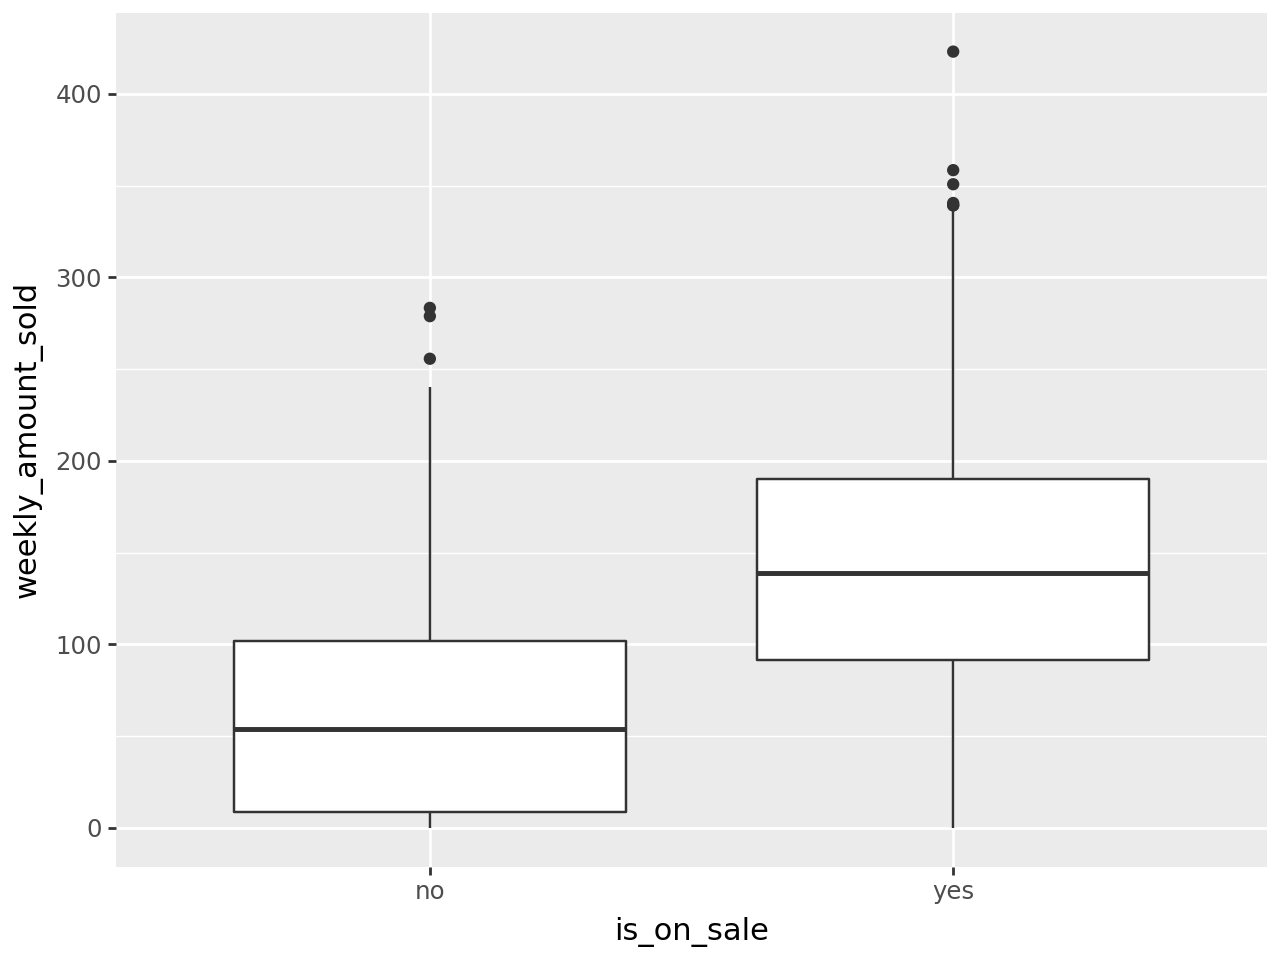

In [37]:
(
    ggplot(data, aes(x="is_on_sale", y="weekly_amount_sold"))
    + geom_boxplot()
)

## Modelos Causales: Resumen y Formalización

Un **modelo causal** es una representación formal de cómo ciertas variables (endógenas) son determinadas por otras variables y factores externos (exógenos). Utilizamos funciones para expresar estas relaciones y distinguir entre variables que modelamos explícitamente y aquellas que dejamos fuera del modelo.

### Notación Formal

- Variables **exógenas** ($u$): factores externos no modelados explícitamente.
- Variables **endógenas**: aquellas que sí modelamos y nos interesan.

Por ejemplo, un modelo causal simple para el efecto de una rebaja en ventas semanales sería:

$$
\begin{align*}
T &\leftarrow f_T(u_t) \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Donde:
- $T$ es el tratamiento (por ejemplo, si hay rebaja: $\texttt{is\_on\_sale}$).
- $Y$ es el resultado ($\texttt{weekly\_amount\_sold}$).
- $u_t$ y $u_y$ son variables exógenas que afectan a $T$ y $Y$, respectivamente.

Esto significa que $T$ es causado por factores externos $u_t$, y $Y$ es causado tanto por $T$ como por otros factores $u_y$.

### Ejemplo con Variables Adicionales

Si creemos que el tamaño del negocio ($\texttt{BusinessSize}$) también influye, el modelo se expande:

$$
\begin{align*}
S &\leftarrow f_S(u_s) \\
T &\leftarrow f_T(S, u_t) \\
Y &\leftarrow f_Y(T, S, u_y)
\end{align*}
$$

Donde:
- $S$ es el tamaño del negocio.
- $T$ (rebaja) depende de $S$ y $u_t$.
- $Y$ (ventas) depende de $T$, $S$ y $u_y$.

Así, $S$ es causa común de $T$ y $Y$.

### Comparación con Modelos Estadísticos

En estadística, esto suele representarse como una regresión lineal:

$$
\text{AmountSold}_i = \alpha + \beta_1 \cdot \text{IsOnSale}_i + \beta_2 \cdot \text{BusinessSize}_i + e_i
$$

- Aquí, $\alpha$ es la constante, $\beta_1$ y $\beta_2$ son los coeficientes, y $e_i$ es el error.
- Este modelo asume una relación lineal y aditiva entre las variables.

### Puntos Clave

- Los modelos causales permiten razonar explícitamente sobre cómo se generan las variables.
- La notación con flechas ($\leftarrow$) enfatiza la direccionalidad y la no reversibilidad de la causalidad.
- Incluir más variables endógenas en el modelo permite explicar mejor las relaciones y evitar confusiones entre asociación y causalidad.

## Intervetions

Las **intervenciones** en modelos causales consisten en modificar directamente una variable (por ejemplo, forzar el tratamiento $T$ a un valor específico $t_0$), ignorando sus causas naturales. Esto se representa formalmente con el operador $\text{do}()$, introducido por Judea Pearl. El objetivo es responder preguntas del tipo: “¿Qué pasaría con el resultado $Y$ si forzamos $T = t_0$?”

Por ejemplo, en un modelo causal simple:

$$
\begin{align*}
T &\leftarrow f_T(u_t) \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Una intervención $\text{do}(T = t_0)$ reemplaza la ecuación de $T$ por $T = t_0$, eliminando la influencia de $u_t$:

$$
\begin{align*}
T &= t_0 \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Esto nos permite calcular el efecto causal de $T$ sobre $Y$.

El valor esperado (o expectativa) de una variable aleatoria $X$ se denota como $\mathbb{E}[X]$ y representa el promedio poblacional. Si queremos saber el valor esperado de $Y$ dado que $X = x$, lo escribimos como $\mathbb{E}[Y \mid X = x]$.

Cuando intervenimos, usamos la notación $\mathbb{E}[Y \mid \text{do}(T = t_0)]$, que significa: “el valor esperado de $Y$ si forzamos $T$ a $t_0$ mediante una intervención”.

En resumen:

- $\mathbb{E}[X]$: esperanza marginal de $X$ (promedio poblacional).
- $\mathbb{E}[Y \mid X = x]$: esperanza condicional de $Y$ dado $X = x$ (promedio de $Y$ para los casos donde $X = x$).
- $\mathbb{E}[Y \mid \text{do}(T = t_0)]$: esperanza de $Y$ bajo la intervención $T = t_0$ (efecto causal de $T$ sobre $Y$).

---

El operador $\text{do}()$ también ilustra por qué la asociación es diferente de la causalidad. Por ejemplo, el promedio de ventas para negocios que hicieron una rebaja, $\mathbb{E}[\text{AmountSold} \mid \text{IsOnSale} = 1]$, puede sobrestimar el efecto promedio que tendría una rebaja si la aplicáramos a todos los negocios, $\mathbb{E}[\text{AmountSold} \mid \text{do}(\text{IsOnSale} = 1)]$. En el primer caso, observamos negocios que eligieron hacer rebajas (probablemente los más grandes), mientras que en el segundo caso, forzamos a todos los negocios a hacer rebajas y medimos el efecto en toda la muestra.

En general:

$$
\mathbb{E}[\text{AmountSold} \mid \text{IsOnSale} = 1] \neq \mathbb{E}[\text{AmountSold} \mid \text{do}(\text{IsOnSale} = 1)]
$$

La diferencia radica en la **selección** versus la **intervención**: al condicionar en ventas, medimos sobre un subconjunto seleccionado de negocios que realmente hicieron rebajas; al intervenir con $\text{do}()$, forzamos la rebaja en todos y medimos sobre toda la muestra.

El operador $\text{do}()$ define cantidades causales que no siempre son observables directamente en los datos. Por ejemplo, no podemos observar $\text{do}(\text{IsOnSale} = 1)$ para todos los negocios, ya que no forzamos a todos a hacer rebajas. Por eso, gran parte de la inferencia causal consiste en encontrar formas de identificar (eliminar) el operador $\text{do}()$ de las expresiones teóricas usando los datos observados.

### Efecto Individual del Tratamiento (ITE)

El operador $\text{do}()$ también permite expresar el **efecto individual del tratamiento** (Individual Treatment Effect, ITE), que es el impacto del tratamiento sobre el resultado para una unidad específica. Formalmente, se define como la diferencia entre dos intervenciones:

$$
\tau_i = Y_i\big|_{\text{do}(T = t_1)} - Y_i\big|_{\text{do}(T = t_0)}
$$

En palabras: el efecto para la unidad $i$ es la diferencia en el resultado de esa unidad bajo tratamiento $t_1$ comparado con $t_0$.

En el contexto de nuestro problema, esto se traduce en el efecto de cambiar $\texttt{IsOnSale}$ de 0 a 1 en $\texttt{AmountSold}$:

$$
\tau_i = \text{AmountSold}_i\big|_{\text{do}(\text{IsOnSale} = 1)} - \text{AmountSold}_i\big|_{\text{do}(\text{IsOnSale} = 0)}
$$

Debido al problema fundamental de la inferencia causal, solo podemos observar uno de los dos términos anteriores para cada unidad: nunca vemos el mismo negocio simultáneamente con y sin rebaja. Por eso, aunque el ITE es una cantidad teórica bien definida, en la práctica necesitamos métodos estadísticos para estimarlo usando los datos observados.